### DoRothEA VS CollecTRI

&emsp;&emsp;&emsp;



<br></br>

### **Data Preparation**

In [ ]:
# Install necessary libraries
%pip install scanpy
%pip install decoupler
%pip install pydeseq2
%pip install adjustText
%pip install omnipath

In [ ]:
# Import Necessary libraries
import scanpy as sc
import decoupler as dc
import omnipath

# Data Manipulation
import numpy as np
import pandas as pd
from anndata import AnnData

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Differential Expression Analysis (DESeq2)
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight
0,MYC,TERT,1
1,SPI1,BGLAP,1
2,SMAD3,JUN,1
3,SMAD4,JUN,1
4,STAT5A,IL2,1
...,...,...,...
43173,NFKB,hsa-miR-143-3p,1
43174,AP1,hsa-miR-206,1
43175,NFKB,hsa-miR-21-5p,1
43176,NFKB,hsa-miR-224-5p,1


In [ ]:
# Retrieve DoRothEA gene regulatory network
dorothea = dc.get_dorothea(organism='human')
dorothea

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


In [ ]:
# Download the data from GEO
!wget 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz' -O counts.txt.gz
!gzip -d -f counts.txt.gz
!mkdir datasets
!mv counts.txt datasets/counts.txt

--2023-08-23 02:40:48--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578642 (1.5M) [application/octet-stream]
Saving to: ‘counts.txt.gz’

counts.txt.gz       100%[===================>]   1.50M  8.11MB/s    in 0.2s    

2023-08-23 02:40:48 (8.11 MB/s) - ‘counts.txt.gz’ saved [1578642/1578642]

mkdir: cannot create directory ‘datasets’: File exists


In [ ]:
# Read raw data and process it
adata_table = pd.read_csv('datasets/counts.txt', index_col=2, sep='\t').iloc[:, 5:].T
adata_table

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


In [ ]:
# Transform to AnnData object
adata = AnnData(adata_table, dtype=np.float32)
adata.var_names_make_unique()

# Visualize adata
adata

AnnData object with n_obs × n_vars = 6 × 64253

In [ ]:
# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Store raw counts in layers
adata.X = np.round(adata.X)
adata.layers['counts'] = adata.X

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


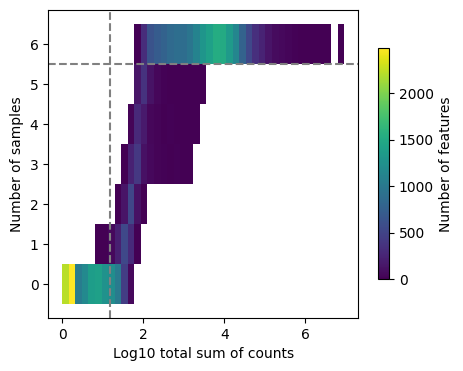

In [ ]:
# Quality Control (optional but recommended)
# --- only the genes in the upper-right corner are going to be kept
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

In [ ]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata_filtered = adata[:, genes].copy()

# Normalize total-count per million, CPM (library-size correct)
sc.pp.normalize_total(adata_filtered, target_sum=1e6)

# Store normalized counts in layers
adata_filtered.layers['cpm'] = adata_filtered.X

# Visualize adata
adata_filtered

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    layers: 'counts', 'cpm'

In [ ]:
# Convert anndata to dataframe
mat = adata_filtered.to_df(layer='cpm')
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0.861613,0.600518,2.637059,1.305475,1.853774,0.496080,20.391516,51.644581,12.323682,628.011658,...,2433.196045,8.929447,12.428120,12.871981,1422.079712,448.665558,33.994560,1412.497559,6.736249,12.402010
26_HSCs-Ctrl2,1.341323,0.914539,2.581031,0.751954,0.975508,0.934862,18.026571,48.328281,9.734755,522.831543,...,2335.406250,7.214693,7.885355,8.860863,1314.862549,428.938904,30.322033,1273.830200,5.141739,8.047939
27_HSCs-Ctrl3,0.969110,0.633649,2.012767,0.838653,1.062294,0.465918,20.779961,56.823406,10.138384,572.576416,...,2895.496338,7.026049,8.162890,8.945633,1596.236328,593.766357,37.888481,1669.087402,5.255559,8.349257
31_HSCs-TGFb1,0.965408,0.536338,2.592299,0.500582,1.841426,0.536338,15.375017,44.802082,7.937799,367.212616,...,1982.054199,6.668467,7.884166,8.599282,1078.485962,348.548065,25.869360,1185.002563,3.075003,6.096373
32_HSCs-TGFb2,1.027534,0.653885,1.821537,0.607179,1.447888,0.607179,9.457981,26.295525,7.146030,227.505325,...,1062.283081,5.581377,7.729856,8.010093,640.854126,211.438431,14.572297,643.026001,2.241892,5.044257
33_HSCs-TGFb3,0.796692,0.522829,2.190902,0.423242,1.468900,0.248966,15.037556,47.253777,7.070639,369.415955,...,1760.290283,8.564435,11.278167,12.373617,1131.376831,343.473694,26.813654,1080.886475,4.780150,6.049877


### **TASK 1** Without DEA

In [ ]:
# Infer TF activities with ulm using CollecTRI network
tf_collectri_acts, tf_collectri_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_collectri_acts

Running ulm on mat with 6 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
25_HSCs-Ctrl1,1.065271,3.514174,-0.092612,9.415961,3.750365,7.373223,2.209566,0.792342,-0.073556,-0.119636,...,2.369573,1.127504,-0.358650,17.150820,-0.152014,0.223821,0.792849,-0.641122,-0.200014,1.450153
26_HSCs-Ctrl2,1.030405,3.440161,-0.108941,9.542375,3.511020,7.276533,2.080410,0.805596,-0.070077,-0.108488,...,2.047039,1.055245,-0.310077,19.225368,-0.127959,0.200879,0.684729,-0.659754,-0.191531,1.307291
27_HSCs-Ctrl3,1.062371,3.424335,-0.105865,9.529013,3.718849,7.010492,2.019162,0.803531,-0.044511,-0.098151,...,2.195054,1.095563,-0.281863,19.751007,-0.130373,0.231463,0.739154,-0.655889,-0.193921,1.433946
31_HSCs-TGFb1,0.341308,2.637717,-0.137230,9.361080,1.861872,8.490873,0.501616,0.297422,-0.033153,-0.101023,...,0.258533,0.462020,-0.082978,16.973499,-0.076632,0.083360,0.223200,-0.273278,-0.090170,0.539290
32_HSCs-TGFb2,0.341225,2.539265,-0.125779,9.222327,1.678781,8.552727,0.517999,0.306156,-0.041591,-0.098005,...,0.221558,0.438267,-0.116582,16.313059,-0.093109,0.047596,0.247153,-0.285465,-0.080965,0.547631
33_HSCs-TGFb3,0.310840,2.437923,-0.130136,9.480180,1.447880,8.714104,0.466991,0.262715,-0.043607,-0.103774,...,0.259031,0.411917,-0.123148,14.640347,-0.087407,0.042552,0.246838,-0.249536,-0.083866,0.495272


In [ ]:
# Infer TF activities with ulm using DoRothEA network
tf_dorothea_acts, tf_dorothea_pvals = dc.run_ulm(mat=mat, net=dorothea, verbose=True)
tf_dorothea_acts

Running ulm on mat with 6 samples and 17575 targets for 281 sources.


,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
25_HSCs-Ctrl1,1.021025,3.672102,0.669420,0.081739,2.697242,0.406054,1.640573,9.651580,0.612182,1.249996,...,1.153498,-0.362572,2.313720,-0.243043,1.458964,0.229465,0.236362,0.888960,-0.119324,0.818194
26_HSCs-Ctrl2,0.837069,3.125694,0.522842,0.059667,2.484215,0.425299,1.518922,11.370332,0.601050,1.228831,...,1.089616,-0.348266,2.313757,-0.225304,1.381372,0.223431,0.209445,0.743970,-0.103534,0.821635
27_HSCs-Ctrl3,0.733383,3.235007,0.362664,0.039752,2.302348,0.379340,1.453873,9.988026,0.632582,1.174902,...,0.941595,-0.352430,2.391180,-0.243337,1.257876,0.177966,0.197441,0.655629,-0.124676,0.821897
31_HSCs-TGFb1,0.146709,1.907928,0.176455,0.030674,1.489451,0.167632,0.882350,24.082785,0.323325,0.646531,...,0.294614,-0.155081,0.951295,-0.236340,0.557984,0.017112,0.024223,0.267921,-0.058887,0.247526
32_HSCs-TGFb2,0.142355,1.933447,0.198555,0.066508,1.523901,0.155078,0.908836,24.428976,0.302630,0.680606,...,0.323040,-0.145260,0.818188,-0.234872,0.546387,0.014625,0.004064,0.317356,-0.036935,0.213974
33_HSCs-TGFb3,0.147991,1.912667,0.190528,0.049037,1.451248,0.150506,0.834354,25.429058,0.284275,0.620398,...,0.334214,-0.142334,0.814386,-0.233600,0.530385,0.006014,-0.006023,0.318166,-0.029797,0.211466


In [ ]:
# Merge two dataframe tables and rename the row names

df_wodea = pd.concat([tf_collectri_acts, tf_dorothea_acts], axis=0, join='inner', sort=False)

df_wodea.index = ['control_25_collectri',
'control_26_collectri',
'control_27_collectri',
'treatment_31_collectri',
'treatment_32_collectri',
'treatment_33_collectri',
'control_25_dorothea',
'control_26_dorothea',
'control_27_dorothea',
'treatment_31_dorothea',
'treatment_32_dorothea',
'treatment_33_dorothea']

df_wodea

,AHR,AR,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,ATF6,...,YY1,ZBED1,ZBTB33,ZBTB7A,ZEB1,ZEB2,ZHX2,ZNF143,ZNF263,ZNF384
control_25_collectri,3.514174,7.373223,0.792342,1.198131,2.654882,2.785618,6.055925,5.635348,3.637159,2.614763,...,8.714533,2.381967,-1.141551,-1.290181,-12.119536,-2.908373,0.385834,0.089185,0.301856,17.150820
control_26_collectri,3.440161,7.276533,0.805596,1.125425,2.602564,2.350545,6.751592,6.185532,3.380883,2.349037,...,9.215158,2.082918,-1.217004,-1.271898,-12.485348,-1.751672,0.340906,0.073344,0.484689,19.225368
control_27_collectri,3.424335,7.010492,0.803531,1.120834,2.618735,2.621866,6.114045,5.626658,3.414508,2.376544,...,9.470370,2.486635,-1.369453,-1.328793,-13.637111,-2.820370,0.338937,0.069132,0.360977,19.751007
treatment_31_collectri,2.637717,8.490873,0.297422,1.457918,1.840117,-0.137179,12.578799,13.257711,1.412893,1.391509,...,6.306425,0.939004,-0.417797,-0.290927,0.344011,16.447584,0.164801,-0.059667,0.085545,16.973499
treatment_32_collectri,2.539265,8.552727,0.306156,1.344687,1.748478,-0.229820,12.703662,13.200921,1.277300,1.351801,...,6.154820,0.714645,-0.352100,-0.208499,0.914140,16.541990,0.159952,-0.077533,0.080785,16.313059
treatment_33_collectri,2.437923,8.714104,0.262715,1.455814,1.637005,-0.143636,13.175382,14.048349,1.349316,1.275929,...,5.731236,0.822617,-0.403420,-0.211855,2.677872,17.677885,0.156315,-0.080887,0.084425,14.640347
control_25_dorothea,1.021025,3.672102,0.081739,2.697242,0.406054,1.640573,9.651580,0.612182,1.249996,4.558923,...,0.120178,0.830512,1.316402,3.326453,7.565353,5.333900,1.065969,0.994335,2.313720,1.458964
control_26_dorothea,0.837069,3.125694,0.059667,2.484215,0.425299,1.518922,11.370332,0.601050,1.228831,4.129574,...,0.217607,0.697465,1.146822,3.189882,7.463068,5.112405,0.990678,1.010351,2.313757,1.381372
control_27_dorothea,0.733383,3.235007,0.039752,2.302348,0.379340,1.453873,9.988026,0.632582,1.174902,4.124211,...,0.147450,0.715891,1.008685,3.540452,7.072588,5.214931,1.036520,1.008025,2.391180,1.257876
treatment_31_dorothea,0.146709,1.907928,0.030674,1.489451,0.167632,0.882350,24.082785,0.323325,0.646531,2.471991,...,0.387642,0.173480,0.386494,1.383473,5.270004,2.422513,0.286167,0.401320,0.951295,0.557984


In [ ]:
# Convert dataframe to anndata object
adata_wodea = sc.AnnData(df_wodea)

# Process sample information
adata_wodea.obs['condition'] = [sample_id.split('_')[0] for sample_id in adata_wodea.obs.index]
adata_wodea.obs['sample_id'] = [sample_id.split('_')[1] for sample_id in adata_wodea.obs.index]
adata_wodea.obs['network'] = [sample_id.split('_')[2] for sample_id in adata_wodea.obs.index]

# Standardize data
sc.pp.scale(adata_wodea)

adata_wodea

AnnData object with n_obs × n_vars = 12 × 241
    obs: 'condition', 'sample_id', 'network'
    var: 'mean', 'std'

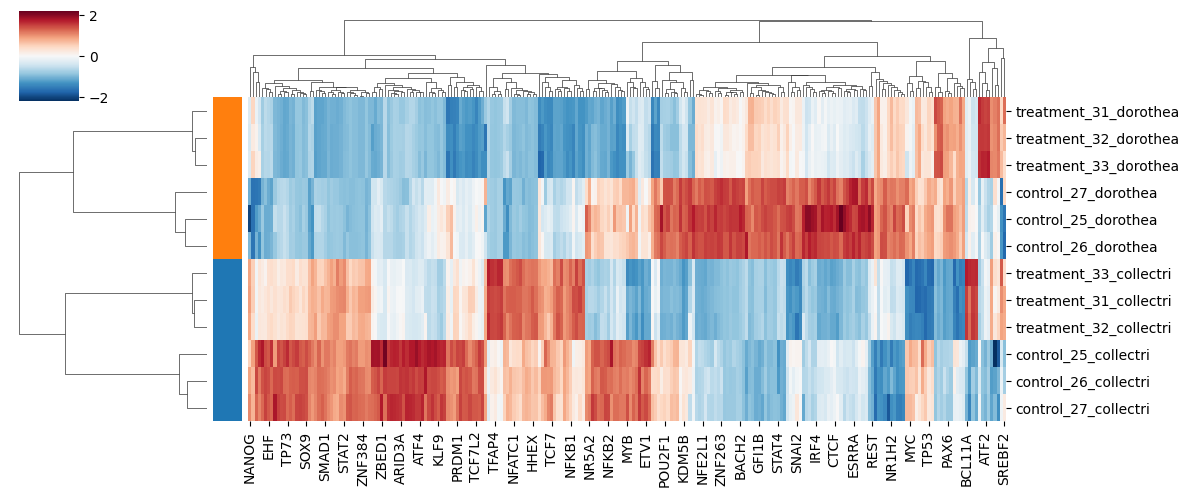

In [ ]:
# sc.tl.dendrogram(adata_wodea, 'network')

# Plot heatmap with row dendrogram
sc.pl.clustermap(adata_wodea, obs_keys='network', cmap="RdBu_r", figsize=(12,5))

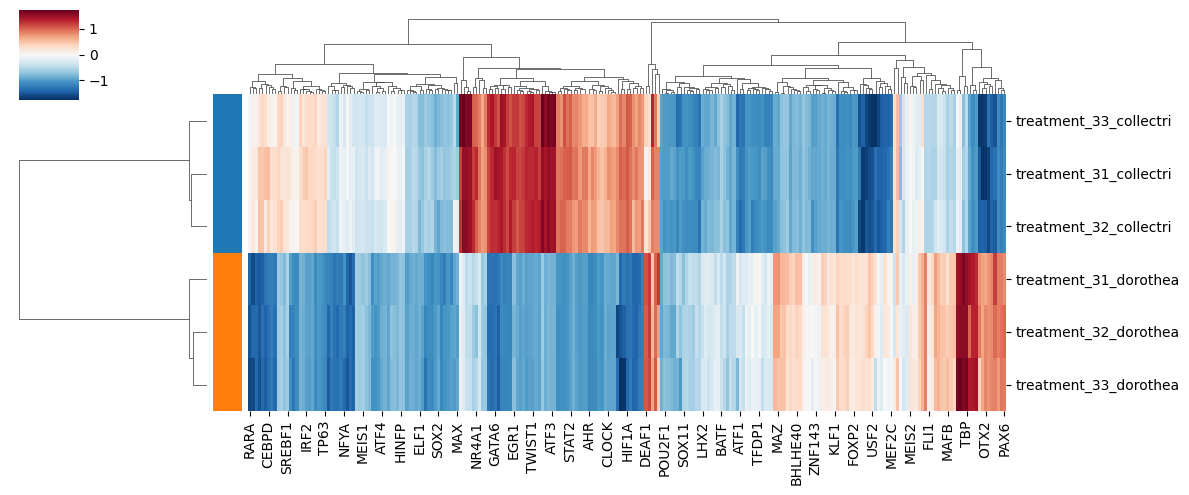

In [ ]:
# Filter the AnnData object based on the condition 'treatment'
adata_wodea_treatment = adata_wodea[adata_wodea.obs['condition'] == 'treatment'].copy()

# Plot heatmap with row dendrogram
sc.pl.clustermap(adata_wodea_treatment, obs_keys='network', cmap="RdBu_r", figsize=(12,5))

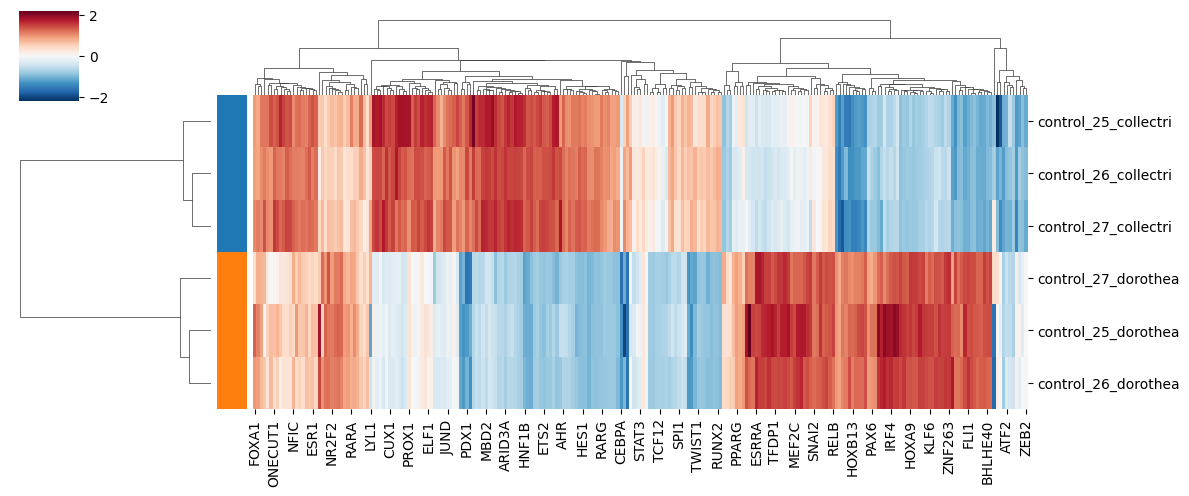

In [ ]:
# Filter the AnnData object based on the condition 'treatment'
adata_wodea_control = adata_wodea[adata_wodea.obs['condition'] == 'control'].copy()

# Plot heatmap with row dendrogram
sc.pl.clustermap(adata_wodea_control, obs_keys='network', cmap="RdBu_r", figsize=(12,5))

         Falling back to preprocessing with `sc.pp.pca` and default params.


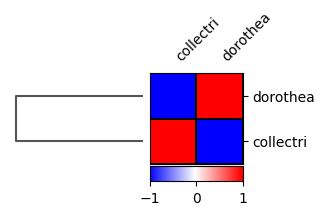

In [ ]:
# Plot the overall pearson correlation of treatment
sc.pl.correlation_matrix(adata_wodea_treatment, groupby='network')

         Falling back to preprocessing with `sc.pp.pca` and default params.


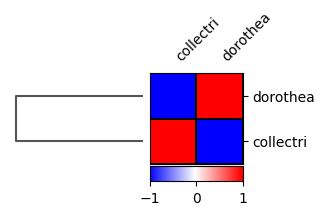

In [ ]:
# Plot the overall pearson correlation of control
sc.pl.correlation_matrix(adata_wodea_control, groupby='network')

In [ ]:
# Calculate correlation between two TF DataFrame Networks
df_treatment_collectri = df_wodea[df_wodea.index.str.contains("treatment") & df_wodea.index.str.contains("collectri")].reset_index(drop=True)
df_treatment_dorothea = df_wodea[df_wodea.index.str.contains("treatment") & df_wodea.index.str.contains("dorothea")].reset_index(drop=True)

correlation_matrix_treatment = df_treatment_collectri.corrwith(df_treatment_dorothea, method='pearson')
correlation_matrix_treatment

AHR      -0.225150
AR       -0.076390
ARID3A    0.175926
ARNT     -0.842089
ASCL1     0.949490
            ...   
ZEB2     -0.309007
ZHX2      0.654849
ZNF143    0.991946
ZNF263    0.663993
ZNF384    0.988236
Length: 241, dtype: float64

In [ ]:
# Calculate correlation between two TF DataFrame Networks
df_control_collectri = df_wodea[df_wodea.index.str.contains("control") & df_wodea.index.str.contains("collectri")].reset_index(drop=True)
df_control_dorothea = df_wodea[df_wodea.index.str.contains("control") & df_wodea.index.str.contains("dorothea")].reset_index(drop=True)

correlation_matrix_control = df_control_collectri.corrwith(df_control_dorothea, method='pearson')
correlation_matrix_control

AHR       0.980441
AR        0.559447
ARID3A   -0.802548
ARNT      0.910991
ASCL1    -0.211455
            ...   
ZEB2     -0.878517
ZHX2      0.773918
ZNF143   -0.944296
ZNF263   -0.199447
ZNF384   -0.895034
Length: 241, dtype: float64

In [ ]:
# Define bins and labels
bins = [-np.inf, -0.5, 0.5, np.inf]
labels = ["anti-correlated", "non-correlated", "correlated"]

# Categorize values
correlation_matrix_treatment_categories = pd.cut(correlation_matrix_treatment, bins=bins, labels=labels)
correlation_matrix_control_categories = pd.cut(correlation_matrix_control, bins=bins, labels=labels)

# Combine data for visualization
df_combined = pd.DataFrame({
    'Value': pd.concat([correlation_matrix_treatment, correlation_matrix_control], axis=0),
    'Category': pd.concat([correlation_matrix_treatment_categories, correlation_matrix_control_categories], axis=0),
    'Type': ['Treatment'] * len(correlation_matrix_treatment) + ['Control'] * len(correlation_matrix_control)
})

df_combined

,Value,Category,Type
AHR,-0.225150,non-correlated,Treatment
AR,-0.076390,non-correlated,Treatment
ARID3A,0.175926,non-correlated,Treatment
ARNT,-0.842089,anti-correlated,Treatment
ASCL1,0.949490,correlated,Treatment
...,...,...,...
ZEB2,-0.878517,anti-correlated,Control
ZHX2,0.773918,correlated,Control
ZNF143,-0.944296,anti-correlated,Control
ZNF263,-0.199447,non-correlated,Control


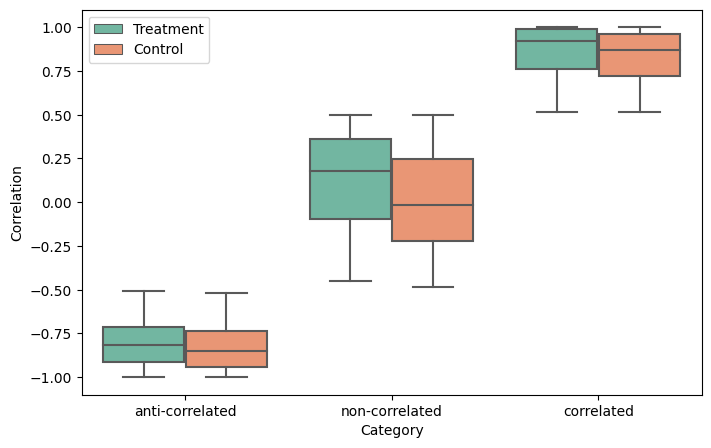

In [ ]:
# Plot BoxPlot between Treatment and Control
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_combined, x="Category", y="Value", hue="Type", palette="Set2", fliersize=0)
# sns.swarmplot(data=df_combined, x="Category", y="Value", hue="Type", dodge=True, palette="Set2", s=3, edgecolor="gray", linewidth=0.3)

# Adjust the legend
plt.legend(loc='upper left')
plt.ylabel("Correlation")
plt.xlabel("Category")
plt.show()


In [ ]:
group_counts = df_combined.groupby(['Type', 'Category']).size().reset_index(name='Count')
group_counts

,Type,Category,Count
0,Control,anti-correlated,57
1,Control,non-correlated,74
2,Control,correlated,110
3,Treatment,anti-correlated,61
4,Treatment,non-correlated,67
5,Treatment,correlated,113


In [ ]:
# Indices where values are "correlated"
treatment_correlated_indices = set(correlation_matrix_treatment[correlation_matrix_treatment_categories == "correlated"].index)
control_correlated_indices = set(correlation_matrix_control[correlation_matrix_control_categories == "correlated"].index)

# Calculate overlap
overlap_indices = list(treatment_correlated_indices.intersection(control_correlated_indices))
overlap_count = len(overlap_indices)

print(f"Number of overlaps: {overlap_count}")
print("Overlap indices:")
print(overlap_indices)

Number of overlaps: 62
Overlap indices:
['HHEX', 'TFDP1', 'CTCF', 'PGR', 'E2F4', 'RELB', 'ETS2', 'ESR2', 'WT1', 'RFX1', 'ZHX2', 'EPAS1', 'FOXP1', 'IRF9', 'SRF', 'NFE2L1', 'POU2F1', 'RELA', 'RFX5', 'STAT4', 'CUX1', 'NRF1', 'NFKB1', 'MYB', 'POU4F2', 'TBP', 'ATF2', 'EHF', 'SREBF2', 'NFIC', 'RBPJ', 'TCF4', 'ERG', 'MBD1', 'SP1', 'TAL1', 'MYCN', 'JUND', 'MYC', 'REL', 'ZBTB33', 'TP53', 'SREBF1', 'NANOG', 'SP3', 'HSF1', 'E2F1', 'FOXO1', 'NR4A1', 'IRF8', 'SOX9', 'ATF6', 'HBP1', 'GLI2', 'CREB1', 'HNF4A', 'FOXA2', 'E2F6', 'ETS1', 'SMAD3', 'FOSL2', 'USF2']


In [ ]:
# Calculate union
all_indices = list(treatment_correlated_indices.union(control_correlated_indices))
all_count = len(all_indices)

print(f"Number of all correlated: {all_count}")
print("All Correlated indices:")
print(all_indices)

Number of all correlated: 161
All Correlated indices:
['CEBPD', 'HHEX', 'NR1H2', 'PAX5', 'FLI1', 'BMAL1', 'MEF2C', 'PPARG', 'SMAD1', 'MNT', 'CUX1', 'SP4', 'NRF1', 'GATA2', 'POU4F2', 'TBP', 'SOX10', 'MAFG', 'STAT6', 'SREBF2', 'AHR', 'RBPJ', 'ZNF263', 'TCF4', 'KMT2A', 'CREB3L1', 'HOXB13', 'SP1', 'TAL1', 'MYC', 'USF1', 'NFYB', 'ZBTB33', 'NANOG', 'SP3', 'E2F1', 'BACH1', 'FOXO1', 'CEBPG', 'ATF6', 'MEIS2', 'TBX21', 'ETS1', 'ATF4', 'KLF6', 'FOSL2', 'CTCF', 'KLF1', 'STAT5B', 'AR', 'ESR2', 'RFX1', 'TFAP2C', 'SMAD5', 'CREB3', 'POU2F2', 'FOXP1', 'IRF9', 'FOSL1', 'POU2F1', 'CLOCK', 'NEUROD1', 'KLF13', 'ATF2', 'CTCFL', 'ERG', 'SPI1', 'MBD1', 'MYBL2', 'FOXL2', 'JUND', 'REL', 'TEAD4', 'NR1H3', 'STAT1', 'GABPA', 'CEBPB', 'HBP1', 'IKZF1', 'KLF5', 'NFKB2', 'PKNOX1', 'TFAP2A', 'E2F4', 'HIF1A', 'RELB', 'ETS2', 'WT1', 'MAF', 'STAT5A', 'ETV1', 'EPAS1', 'ZEB1', 'SRF', 'NFE2L1', 'RELA', 'VDR', 'EOMES', 'RFX5', 'E2F7', 'MYB', 'EHF', 'HINFP', 'ATF1', 'SOX6', 'ZNF384', 'EGR1', 'ZNF143', 'MYCN', 'YY1', 'NR2F1', '

In [ ]:
# Filter only correlated TF
adata_wodea_correlated = adata_wodea[:, all_indices].copy()

adata_wodea_correlated

AnnData object with n_obs × n_vars = 12 × 161
    obs: 'condition', 'sample_id', 'network'
    var: 'mean', 'std'
    uns: 'network_colors'

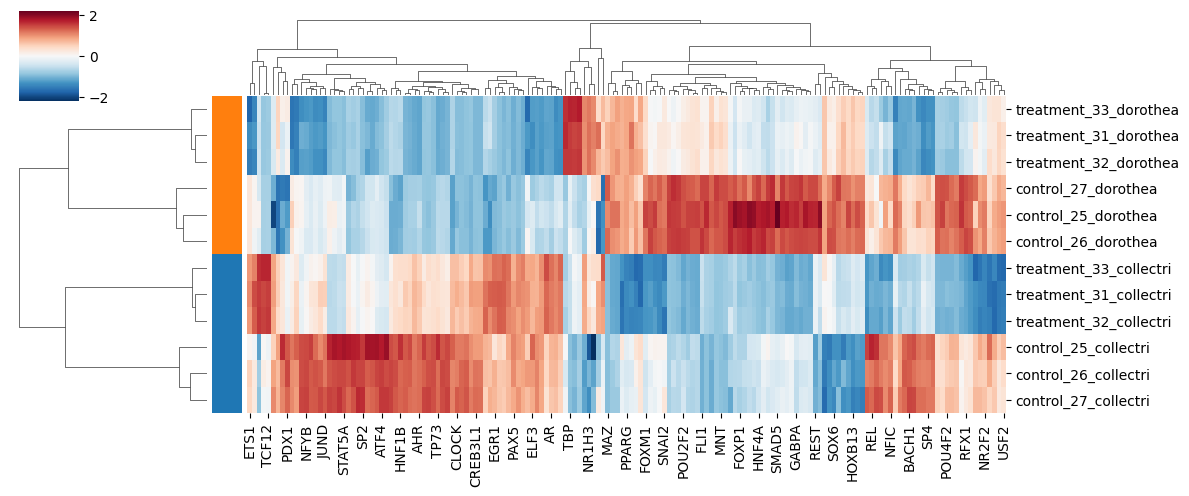

In [ ]:
# Plot heatmap with row dendrogram
sc.pl.clustermap(adata_wodea_correlated,
                 obs_keys='network',
                 cmap="RdBu_r",
                 figsize=(12,5))

In [ ]:
# Filter only correlated TF
adata_wodea_correlated_overlap = adata_wodea[:, overlap_indices].copy()

adata_wodea_correlated_overlap

AnnData object with n_obs × n_vars = 12 × 62
    obs: 'condition', 'sample_id', 'network'
    var: 'mean', 'std'
    uns: 'network_colors'

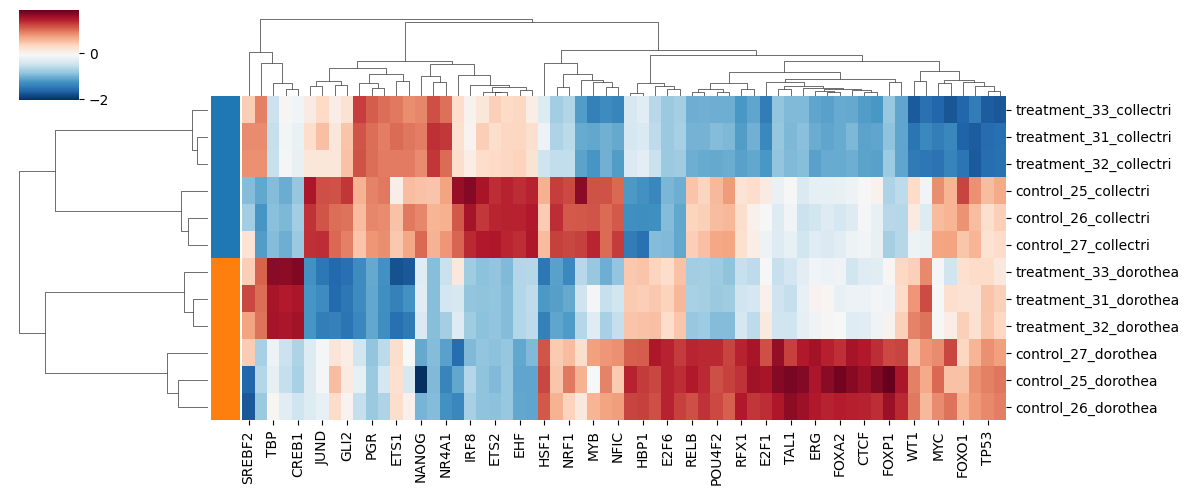

In [ ]:
# Plot heatmap with row dendrogram
sc.pl.clustermap(adata_wodea_correlated_overlap,
                 obs_keys='network',
                 cmap="RdBu_r",
                 figsize=(12,5))

### **TASK 2** With DEA

In [ ]:
# Build DESeq2 object
dds = DeseqDataSet(
    adata=adata_filtered,
    design_factors='condition',
    refit_cooks=True,
    n_cpus=8,
)
dds

AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    obsm: 'design_matrix'
    layers: 'counts'

In [ ]:
# Compute LFCs
dds.deseq2()
dds

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 217.05 seconds.

Fitting dispersion trend curve...
... done in 8.38 seconds.

Fitting MAP dispersions...
... done in 215.03 seconds.

Fitting LFCs...
... done in 13.95 seconds.

Refitting 0 outliers.



AnnData object with n_obs × n_vars = 6 × 17575
    obs: 'condition', 'sample_id'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors'
    varm: 'non_zero', '_rough_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'counts', 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [ ]:
# Extract contrast between treatment vs normal
stat_res = DeseqStats(dds, contrast=["condition", 'treatment', 'control'], n_cpus=8)

# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 4.51 seconds.



Log2 fold change & Wald test p-value: condition treatment vs control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.067094,0.294257,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.086227,0.249617,-0.345438,0.729765,0.801351
CICP27,106.257057,0.144798,0.177248,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.634443,0.286075,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.579098,0.270626,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.445816,0.278378,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.343227,0.287943,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.323882,0.302438,-1.070903,0.284213,0.387995


In [ ]:
# Shrink LFCs
stat_res.lfc_shrink(coeff='condition_treatment_vs_control')

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition treatment vs control


... done in 30.00 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


In [ ]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
RP11-34P13.7,45.820190,0.050407,0.271447,0.228010,0.819639,0.871654
RP11-34P13.8,29.560568,-0.068949,0.234608,-0.345438,0.729765,0.801351
CICP27,106.257057,0.129368,0.172303,0.816925,0.413971,0.521994
FO538757.2,33.114796,-0.523892,0.280505,-2.217747,0.026572,0.050794
AP006222.2,67.154701,0.483006,0.266258,2.139848,0.032367,0.060587
...,...,...,...,...,...,...
MT-ND6,17962.507812,-0.240886,0.260519,-1.601475,0.109272,0.175000
MT-TE,1284.633179,-0.265368,0.273098,-1.191996,0.233263,0.330373
MT-CYB,55097.121094,-0.523154,0.297741,-1.070903,0.284213,0.387995


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


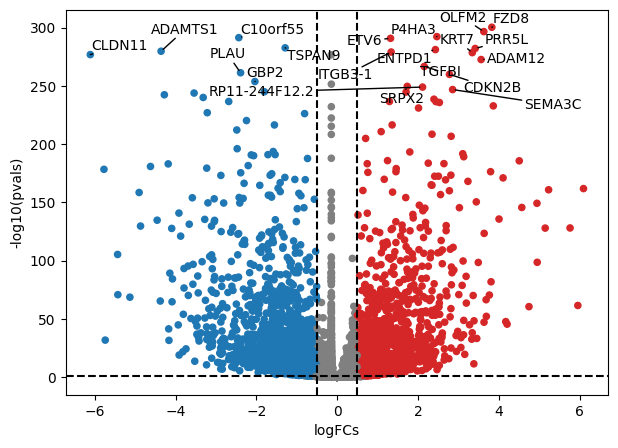

In [ ]:
# Show Vocano Plot
dc.plot_volcano_df(results_df, x='log2FoldChange', y='padj', top=20)

In [ ]:
# Obtain gene level statistics to perform enrichment analysis
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,AC114498.1,MIR6723,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,0.22801,-0.345438,0.816925,-2.217747,2.139848,-0.422515,-1.373661,-0.53866,-2.845663,-3.862065,...,-1.472827,0.550156,0.704443,1.049607,-1.283784,-1.601475,-1.191996,-1.070903,-1.49019,-2.362806


CollecTRI network

In [ ]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 17575 targets for 629 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
treatment.vs.control,-1.757384,-2.041384,-1.317279,-2.718626,-2.338566,0.178862,-6.440889,1.410645,2.23343,-0.704304,...,-1.164067,-0.933561,2.687689,1.49982,-1.249087,-1.407577,-0.820753,0.485726,2.157699,0.86518


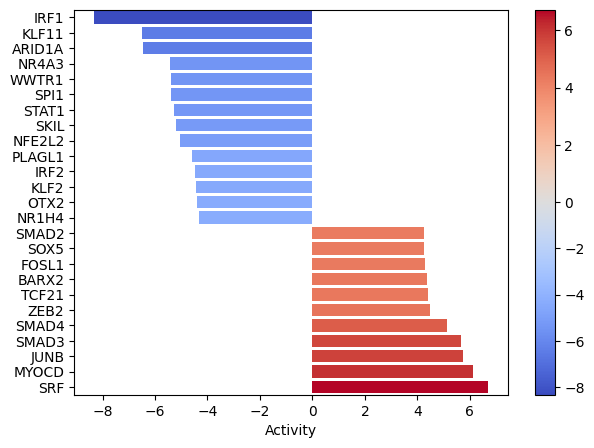

In [ ]:
# Show the obtained scores for the top active/inactive transcription factors
dc.plot_barplot(tf_acts, 'treatment.vs.control', top=25, vertical=True)

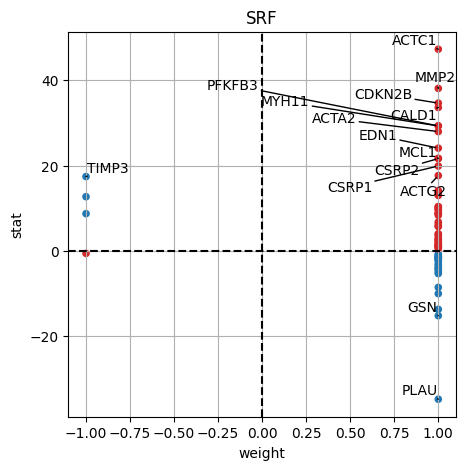

In [ ]:
# Manually inspect the downstream targets of each transcription factor
dc.plot_targets(results_df, stat='stat', source_name='SRF', net=collectri, top=15)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


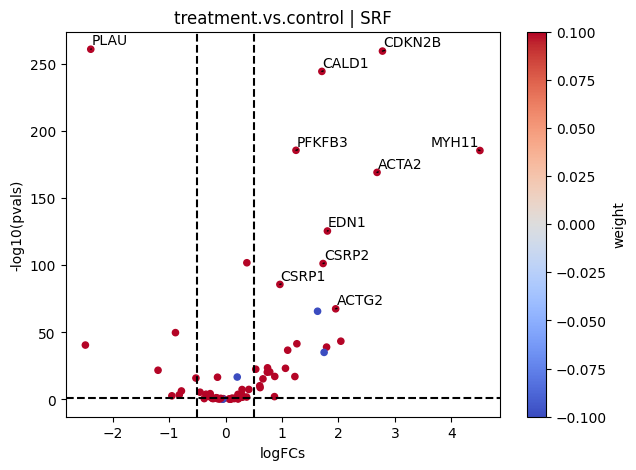

In [ ]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'treatment.vs.control'})
pvals = results_df[['padj']].T.rename(index={'padj': 'treatment.vs.control'})

# Plot
dc.plot_volcano(logFCs, pvals, 'treatment.vs.control', name='SRF', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)